In [ ]:
from sklearn.neighbors import KernelDensity
import sys
sys.path.append('/mnt/users/hollowayp/paltas')
from KDE_one_stop import drop_extra_columns,hyperparam_range_dict,one_stop_kde
from Save_Summary_Batches import summary_batch
from squash_walkers import squash_walkers
from load_h5_file import load_h5_file
import matplotlib.pyplot as pl
from KDEpy import TreeKDE
import pandas as pd
import numpy as np
import pickle
import corner


In [ ]:
import pickle
with open('/mnt/extraspace/hollowayp/zBEAMS_data/class_instances/one_stop_kde_subbatch', 'rb') as f:
    data = pickle.load(f)

In [ ]:
print('Loading data')
db = pd.read_csv('./test_data_for_download.csv')
db.drop('Unnamed: 0', axis=1, inplace=True)

db = db[['OM',
         'Ode','w','wa',
    'alpha_scale_0','alpha_scale_1',
    'alpha_scale_2',
    'alpha_mu_0','alpha_mu_1','alpha_mu_2',
    'alpha_weights_0','alpha_weights_1',
    's_c','s_m',
    'scale_c','scale_m']]

# db = db[['OM',
#         #  'Ode','w','wa',
#     # 'alpha_scale_0','alpha_scale_1',
#     'alpha_scale_2',
#     # 'alpha_mu_0','alpha_mu_1','alpha_mu_2',
#     'alpha_weights_0','alpha_weights_1',
#     # 's_c','s_m',
#     'scale_c','scale_m']]

range_dict = {elem: [db[elem].min(), db[elem].max()] for elem in db.columns}
range_min_array = np.array([range_dict[elem][0] for elem in db.columns])
range_max_array = np.array([range_dict[elem][1] for elem in db.columns])

db = ((db-range_min_array)/(range_max_array-range_min_array)) #Rescaling to [0,1]


In [ ]:
N_comp = 1000;type='KDE'
samples_equal = pd.read_csv(f'/mnt/extraspace/hollowayp/zBEAMS_data/dynesty_samples/dynesty_samples_{type}_{N_comp}.csv')
samples_equal.drop('Unnamed: 0', axis=1, inplace=True)

#### GMM Approximation

In [ ]:
fig = pl.figure(figsize=(30,30))
corner.corner(samples_equal,labels=db.columns.tolist(),fig=fig,plot_datapoints=False,
hist_kwargs={'density':True},
hist2d_kwargs={'label':'_nolegend_'},color='k',bins=50)

# corner.corner(G1000.sample(len(db))[0],labels=db.columns.tolist(),fig=fig,plot_datapoints=False,
# hist_kwargs={'density':True},
# hist2d_kwargs={'label':'_nolegend_'},color='green',bins=50)

corner.corner(db,labels=db.columns.tolist(),fig=fig,plot_datapoints=False,
hist_kwargs={'density':True},
hist2d_kwargs={'label':'_nolegend_'},color='darkred',bins=50)
pl.tight_layout()
pl.show()

In [ ]:

# kernel='gaussian';bandwidth=0.01

# kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(db.to_numpy())

# kde = TreeKDE(kernel=kernel, bw=bandwidth).fit(data=db.to_numpy())

In [ ]:
fig = pl.figure(figsize=(30,30))
corner.corner(db,labels=db.columns.tolist(),fig=fig,plot_datapoints=False,
hist_kwargs={'density':True},
hist2d_kwargs={'label':'_nolegend_'},color='darkred',bins=50)
pl.tight_layout()

corner.corner(kde.sample(len(db)),labels=db.columns.tolist(),fig=fig,plot_datapoints=False,
hist_kwargs={'density':True},
hist2d_kwargs={'label':'_nolegend_'},color='k',bins=50)
pl.tight_layout()
pl.show()

#### Parallel Tempering

In [ ]:
temp_indx = 0
param_indx = 0
for chain_indx in range(10):
    pl.plot(ptemcee_samples[temp_indx,chain_indx,:,param_indx],alpha=0.5)
pl.show()

In [ ]:
reload(sys.modules['run_ptemcee'])
from run_ptemcee import run_ptemcee,gaussian_kde_product_log_prob,log_prior
sampler = run_ptemcee(db,kde,ntemps=50,n_burnin=1,n_steps=1000,n_thin=1)
ptemcee_samples = sampler.chain


In [ ]:
ptemcee_samples.shape

In [ ]:
for ntemps in [5,10,20,50,100]:
    print(ntemps)
    n_params = '_16'
    ptemcee_samples = load_h5_file(f'/mnt/extraspace/hollowayp/zBEAMS_data/ptemcee_samples/ptemcee_chain_{ntemps}{n_params}.h5')
    ptemcee_samples.shape

    fig = pl.figure(figsize=(30,30))
    corner.corner(db,labels=db.columns.tolist(),fig=fig,plot_datapoints=False,
    hist_kwargs={'density':True},
    hist2d_kwargs={'label':'_nolegend_'},color='darkred',bins=20,range=[(0,1) for i in range(len(db.columns))])
    pl.tight_layout()

    # corner.corner(kde.sample(len(db)),labels=db.columns.tolist(),fig=fig,plot_datapoints=False,
    # hist_kwargs={'density':True},
    # hist2d_kwargs={'label':'_nolegend_'},color='k',bins=50)

    burnin = 0
    corner.corner(ptemcee_samples[0,:,burnin:,:].reshape((-1,len(db.columns))),labels=db.columns.tolist(),fig=fig,plot_datapoints=False,
    hist_kwargs={'density':True},
    hist2d_kwargs={'label':'_nolegend_'},color='k',bins=20,range=[(0,1) for i in range(len(db.columns))])
    pl.tight_layout()
    # pl.savefig('./ptemcee_corner_plot.png')
    # pl.close()
    pl.show()



#### KDE weighted Posterior (without MCMC)

In [ ]:
#Works good with 3 dimensions, bandwidth = 0.05, metric=infin. 100,000 datapoints in db_0.
#Works good with 6 dimensions and 12, bandwidth = 0.5.
#Works good with 16 dimensions, bandwidth = 0.3.

In [ ]:
N_dim = 16
print('Generating Data')
# db_toy_0 = pd.DataFrame(np.random.normal(loc=0,scale=1,size=(100000,N_dim)))
# db_toy_1 = pd.DataFrame(np.random.normal(loc=0,scale=1,size=(10000,N_dim)))
# db_prod = pd.DataFrame(np.random.normal(loc=0,scale=1/np.sqrt(2),size=(10000,N_dim)))
db_toy_0 = db[0];db_toy_1 = db[1]

# db_lim = pd.concat([db_toy_0,db_toy_1],axis=0)
# db_toy_0 = (db_toy_0-db_lim.min().to_numpy())/(db_lim.max().to_numpy()-db_lim.min().to_numpy())
# db_toy_1 = (db_toy_1-db_lim.min().to_numpy())/(db_lim.max().to_numpy()-db_lim.min().to_numpy())
# db_prod = (db_prod-db_lim.min().to_numpy())/(db_lim.max().to_numpy()-db_lim.min().to_numpy())

# uniform_random = np.random.uniform(-lim,lim,size=(1000000,N_dim))
lim = 1
print('Running KDE')
# kde_toy_0 = KernelDensity(bandwidth=0.5,kernel='gaussian',metric='infinity').fit(db_toy_0.to_numpy())
# kde_toy_1 = KernelDensity(bandwidth=0.5,kernel='gaussian',metric='infinity').fit(db_toy_1.to_numpy())
print('Corner Plotting')
fig = pl.figure(figsize=(2*N_dim,2*N_dim))
corner_dict = {'bins':30,
            #    'range':[(0,lim) for elem in range(N_dim)],
               'plot_datapoints':False,'fig':fig}
print('Plotting 1')
corner.corner(db_toy_0,color='red',**corner_dict,hist_kwargs={'density':True})
corner.corner(db_toy_1,color='blue',hist_kwargs={'density':True},**corner_dict)
# corner.corner(kde_toy_0.sample(len(db_toy_0)),fig=fig,color='k',hist_kwargs={'density':True})
print('Plotting 2')
# weights_0_1 = np.exp(kde_toy_0.score_samples(db_toy_1.to_numpy()))
# weights_1_0 = np.exp(kde_toy_1.score_samples(db_toy_0.to_numpy()))
corner.corner(db_toy_0,weights=weights_1_0,hist_kwargs={'density':True},color='purple',**corner_dict)
corner.corner(db_toy_1,weights=weights_0_1,hist_kwargs={'density':True},color='green',**corner_dict)
print('Plotting 3')
# corner.corner(db_prod,color='green',**corner_dict,hist_kwargs={'density':True})
# corner.corner(uniform_random,weights = np.exp(kde_toy_0.score_samples(uniform_random)),hist_kwargs={'density':True},color='purple',**corner_dict)
pl.tight_layout()
pl.show()
# assert False - must be a bug as it doesn't square the answer when I weight a db by its own KDE?

In [ ]:
for k_i in test_data_dict.keys():
    print(np.sum(np.sum(np.isnan(test_data_dict[k_i]))))

In [ ]:
db = test_data_dict

# range_dict = {elem: [np.min([np.min(db[k_i][elem]) for k_i in db.keys()]),
#                      np.max([np.max(db[k_i][elem]) for k_i in db.keys()])] for elem in db[0].columns}
# range_min_array = np.array([range_dict[elem][0] for elem in db[0].columns])
# range_max_array = np.array([range_dict[elem][1] for elem in db[0].columns])

# for k_i in db.keys():
#     db[k_i] = ((db[k_i]-range_min_array)/(range_max_array-range_min_array))

std_dict = np.array([np.mean([np.std(db[k_i][elem]) for k_i in db.keys()]) for elem in db[0].columns])
for k_i in db.keys():
    db[k_i] = ((db[k_i]/std_dict))


#### Corner Plots

In [ ]:
from plot_JAX_corner import label_dict
from tqdm import tqdm
import corner
def plot_kde_corner(self,only_cosmo=False,extra_data = None,save_as=None):
    truth_dict = {'OM':0.3,'Ode':0.7,'w':-1,'wa':0,'Ok':0}
    try: self.kde_dict
    except: self.determine_kde()
    try: self.weights_dict
    except: self.calculate_weights()
    print('Starting Corner Plot')
    if only_cosmo:
        columns_to_plot = ['OM','Ode','w','wa']#,'Ok']
        range_list = [hyperparam_range_dict[k_i] for k_i in columns_to_plot]
        label_list = [label_dict[k_i] for k_i in columns_to_plot]
        N_dim = len(columns_to_plot)
        truths = [truth_dict[k_i] for k_i in columns_to_plot]
    else:
        N_dim = len(self.JAX_chain_dict[0].columns)
        range_list = [hyperparam_range_dict[k_i] for k_i in self.JAX_chain_dict[0].columns]
        label_list = None
        columns_to_plot = self.JAX_chain_dict[0].columns
        truths=None
    fig = pl.figure(figsize=(2*N_dim,2*N_dim))
    corner_dict = {'bins':30,
                'range':range_list,
                'plot_datapoints':False,'fig':fig,'labels':label_list,'truths':truths, 'truth_color':'k'}
    self.total_weights = []
    for dataset_0_key in tqdm(self.scaled_JAX_chain_dict.keys()):
        dataset_0 = self.JAX_chain_dict[dataset_0_key]
        scaled_dataset_0 = self.scaled_JAX_chain_dict[dataset_0_key]
        weights = np.zeros(len(dataset_0))
        for additional_weights_key in self.scaled_JAX_chain_dict.keys():
            if dataset_0_key==additional_weights_key: continue
            weights+=self.weights_dict[additional_weights_key][dataset_0_key]
        corner.corner(dataset_0[columns_to_plot],                color='red',hist_kwargs={'density':True},**corner_dict)
        corner.corner(dataset_0[columns_to_plot],weights=weights,color='grey',hist_kwargs={'density':True},**corner_dict)
        pl.tight_layout()
        self.total_weights.extend(weights)
    # return self
    corner.corner(pd.concat(self.JAX_chain_dict)[columns_to_plot],weights=self.total_weights,
                    color='k',hist_kwargs={'density':True},**corner_dict)
    if extra_data is not None:
        corner.corner(extra_data[columns_to_plot],color='blue',hist_kwargs={'density':True},**corner_dict)
    if save_as is not None:
        pl.savefig(save_as)
        pl.close()
    else: pl.show()
    print('Finished Corner Plot')
    return self


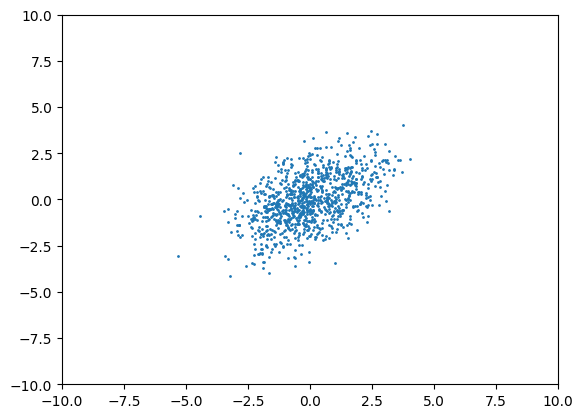

In [12]:
from scipy.stats import multivariate_normal as mvn
import numpy as np
import matplotlib.pyplot as pl
mvn_rvs = mvn(np.zeros(2),[[2,1],[1,2]]).rvs(1000)
pl.scatter(mvn_rvs[:,0],mvn_rvs[:,1],s=1)
pl.xlim(-10,10)
pl.ylim(-10,10)
pl.show()

In [ ]:
with open('/mnt/extraspace/hollowayp/zBEAMS_data/class_instances/python3.11-Subbatching_0_0-64171.out_10_10_pickle.pkl', 'rb') as f:
    summary_batch_subbatching = pickle.load(f)

In [ ]:
import pandas as pd
db = pd.read_csv('/mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_0.csv_ph_True_con_True_wCDM_JAX_chains_21_0_16364_warmup.csv')
# list(db.filter(like='zL').columns)

#### KDE Optimisation

In [ ]:
X_plot = np.linspace(0,1,10000)
OM_samples = squash_walkers(summary_batch_subbatching.JAX_chains_list[0].filter(like='OM')).to_numpy()
OM_samples_2 = squash_walkers(summary_batch_subbatching.JAX_chains_list[1].filter(like='OM')).to_numpy()
for kernel in ['tophat','gaussian']:
    for bandwidth in tqdm([0.01,0.05,0.1,0.5,1.0]):
        kde_OM = KernelDensity(bandwidth=bandwidth,kernel=kernel).fit(np.array(OM_samples))
        OM_score_2 = np.exp(kde_OM.score_samples(OM_samples_2))
        pl.plot(X_plot,np.exp(kde_OM.score_samples(X_plot.reshape(-1,1))),
                label=f'{kernel}, {bandwidth},'+\
                f' Score: {np.round(np.mean(OM_score_2),3)},{np.round(np.median(OM_score_2),3)}')
pl.legend()
pl.show()

In [ ]:
# with open('/mnt/extraspace/hollowayp/zBEAMS_data/class_instances/python3.11-Fiducial_0_0-63921.out_5_10_pickle.pkl','rb') as f:
#     summary_batch_fiducial = pickle.load(f)

for extra_str in ['_True_0','_True_1']:#'']:
    for metric in ['infinity','euclidean']:
        for kernel in ['gaussian']:#,'tophat','exponential']:
            for bandwidth in [1.0]:#[0.001,0.01,0.05,0.1,0.2,0.5,1.0]:
                with open(f'/mnt/extraspace/hollowayp/zBEAMS_data/class_instances/'+\
                        f'one_stop_kde_subbatch_{metric}_{kernel}_{bandwidth}{extra_str}.pkl', 'rb') as f:
                    osk = pickle.load(f)
                    print(metric,kernel,bandwidth)
                    plot_kde_corner(osk,only_cosmo=True,
                                extra_data = squash_walkers(drop_extra_columns(summary_batch_fiducial.JAX_chains_list[0])),
                                # save_as = f'/mnt/extraspace/hollowayp/zBEAMS_data/corner_plots/one_stop_kde_subbatch_{metric}_{kernel}_{bandwidth}.png'
                                )

#### KDE (without MCMC) Results

In [ ]:
import sys
from importlib import reload
reload(sys.modules['KDE_one_stop'])
from KDE_one_stop import one_stop_kde

osk_subbatching_dict = {}
for kernel in ['gaussian']:
    for metric in ['infinity']:
        for bandwidth in [0.01,0.1,0.3,0.5,1.0]:
            test_data_dict = {}
            for chain_i in tqdm(range(5)):
                test_data_dict[chain_i] = squash_walkers(drop_extra_columns(summary_batch_subbatching.JAX_chains_list[chain_i],#.loc[:1999],
                                                                            Ok=True,alpha_weights_2=True))
            osk_subbatching_dict[(kernel,metric,bandwidth)] = one_stop_kde(test_data_dict,
                                                                       bandwidth = bandwidth,
                                                                       kernel=kernel,
                                                                       metric=metric).calculate_weights()

for k_i in osk_subbatching_dict.keys():
    plot_kde_corner(osk_subbatching_dict[k_i],only_cosmo=True)
                                              

In [4]:
import os
os.getcwd()

'/mnt/users/hollowayp/zBEAMS'

In [26]:
#Renaming .out files so they can be concatenated:
import glob
for file_i in glob.glob('/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_*_*-*.out'):
    batch_i = int(file_i.split('Subbatching_')[-1].split('_')[0])
    chain_i = int(file_i.split('Subbatching_')[-1].split('_')[1].split('-')[0])
    print(file_i,batch_i,chain_i)
    # !cp {file_i} /mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_cp_{batch_i}_{chain_i}_{100*batch_i+chain_i}.out

/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_8_14-75944.out 8 14
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_1_17-75666.out 1 17
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_4_2-75771.out 4 2
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_5_18-75827.out 5 18
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_6_14-75863.out 6 14
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_7_5-75894.out 7 5
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_9_5-75975.out 9 5
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_5_14-75823.out 5 14
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_3_33-75762.out 3 33
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_3_23-75752.out 3 23
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_9_28-75998.out 9 28
/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_2_23-75712.out 2 23
/mnt/extraspace/hollowayp/zBEAMS_d

In [ ]:
from Summary_Plots_Class import summary_plots
from tqdm.notebook import tqdm
for b_i in tqdm(range(10)):
    db_tot = pd.DataFrame
    for c_i in tqdm(range(40)):
        db_i = squash_walkers(drop_extra_columns(summary_plots(f'/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_cp_{b_i}_{c_i}_{100*b_i+c_i}.out').JAX_chains,
                        Ok=True,alpha_weights_2=True))
        if c_i==0: db_tot = db_i.copy()
        else: db_tot = pd.concat([db_tot,db_i]).reset_index(drop=True)
    db_tot.to_csv(f'/mnt/extraspace/hollowayp/zBEAMS_data/python3.11-Subbatching_cp_total_{b_i}.out')
